## Data Preparation

In [1]:
import pandas as pd
df = (
    pd.read_csv("df_clean.csv", index_col = 0)
    .assign(action_token = lambda d: pd.Categorical(d.action_token))
)

vocab = df['action_token'].cat.categories

df

,match_id,action_token,dataset
0,315,"True,pass,4,4",train
1,315,"True,receival,4,5",train
2,315,"True,dribble,4,5",train
3,315,"True,pass,5,5",train
4,315,"True,receival,6,4",train
...,...,...,...
939915,82,"False,receival,8,0",test
939916,82,"False,dribble,8,0",test
939917,82,"True,tackle,9,0",test
939918,82,"True,dribble,9,0",test


## Prepare Model

In [2]:
import torch
from models.transformer import BasicTransformer

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

model = BasicTransformer(len(vocab), 50, 2, 500, 1, 0.0).to(device=device)
model.load_state_dict(torch.load("model_weights_v3.pt", map_location=torch.device('cpu')))
model.eval()

BasicTransformer(
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=50, out_features=50, bias=True)
        )
        (linear1): Linear(in_features=50, out_features=500, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=500, out_features=50, bias=True)
        (norm1): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
    (norm): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
  )
  (decoder): Linear(in_features=50, out_features=3015, bias=True)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (input_emb): Embedding(3015, 50)
)

In [3]:
counts = pd.read_csv("transition_counts.csv", index_col = 0)
counts_smoothed = counts + 1
probs = counts_smoothed / counts_smoothed.sum()

def pred_markov(tok):
    return vocab[counts[tok].argmax()]

def prob_markov(tok1, tok2):
    return probs[tok1][tok2]

## Quantitative Evaluation

In [4]:
markov_results = (
    df
    .assign(
        y_true = lambda d: d.action_token.shift(-1),
        y_pred_markov = lambda d: d.action_token.apply(pred_markov),
        accuracy_markov = lambda d: d.y_true == d.y_pred_markov
    )
    .dropna()
    .assign(
        p_markov = lambda d: d.apply(lambda x: prob_markov(x.action_token, x.y_true), axis=1)
    )
)

markov_results

,match_id,action_token,dataset,y_true,y_pred_markov,accuracy_markov,p_markov
0,315,"True,pass,4,4",train,"True,receival,4,5","True,receival,5,5",False,0.010556
1,315,"True,receival,4,5",train,"True,dribble,4,5","True,dribble,4,5",True,0.223239
2,315,"True,dribble,4,5",train,"True,pass,5,5","True,pass,4,5",False,0.014695
3,315,"True,pass,5,5",train,"True,receival,6,4","True,receival,4,4",False,0.006934
4,315,"True,receival,6,4",train,"True,dribble,6,4","True,dribble,6,4",True,0.205905
...,...,...,...,...,...,...,...
939914,82,"False,pass,7,0",test,"False,receival,8,0","False,receival,6,0",False,0.018408
939915,82,"False,receival,8,0",test,"False,dribble,8,0","False,dribble,8,0",True,0.172009
939916,82,"False,dribble,8,0",test,"True,tackle,9,0","False,pass,8,0",False,0.003123
939917,82,"True,tackle,9,0",test,"True,dribble,9,0","True,dribble,9,0",True,0.012804


In [5]:
import numpy as np
from tqdm import tqdm

X = np.lib.stride_tricks.sliding_window_view(df['action_token'].map(list(vocab).index), (9,))

data_loader = torch.utils.data.DataLoader(
    list(zip(X[:-1], X[1:, -1])),
    batch_size=500
)

preds = []
probs = []
for x_bat, y_bat in tqdm(data_loader):
    out = model(x_bat.to(device = device))
    preds.append(out[:, -1, :].argmax(dim = 1))
    probs.append(torch.softmax(out[:, -1], dim=1).gather(1, y_bat.unsqueeze(1)).squeeze().detach().numpy())

preds = torch.concat(preds)
probs = np.concatenate(probs)

  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\ethan\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\_utils\collate.py:171: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ..\torch\csrc\utils\tensor_numpy.cpp:212.)
  return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)
100%|██████████| 100/100 [00:16<00:00,  6.22it/s]


In [6]:
results = (
    markov_results
    .iloc[8:]
    .assign(
        y_pred_transformer = vocab[preds],
        accuracy_transformer = lambda d: d.y_true == d.y_pred_transformer,
        p_transformer = probs
    )
)

results

,match_id,action_token,dataset,y_true,y_pred_markov,accuracy_markov,p_markov,y_pred_transformer,accuracy_transformer,p_transformer
8,315,"True,dribble,6,2",train,"True,pass,6,2","True,pass,6,2",True,0.124765,"True,pass,6,2",True,0.472101
9,315,"True,pass,6,2",train,"True,receival,5,3","True,receival,5,0",False,0.012551,"True,receival,5,0",False,0.034543
10,315,"True,receival,5,3",train,"True,dribble,5,3","True,dribble,5,3",True,0.236842,"True,dribble,5,3",True,0.863836
11,315,"True,dribble,5,3",train,"True,pass,5,2","True,pass,5,3",False,0.028551,"True,pass,5,3",False,0.109498
12,315,"True,pass,5,2",train,"True,receival,4,0","True,receival,5,0",False,0.013072,"True,receival,5,0",False,0.057885
...,...,...,...,...,...,...,...,...,...,...
50002,261,"False,tackle,5,9",train,"False,dribble,5,9","False,dribble,5,9",True,0.019175,"False,dribble,5,9",True,0.589320
50003,261,"False,dribble,5,9",train,"False,pass,5,9","False,pass,5,9",True,0.188691,"False,pass,5,9",True,0.279170
50004,261,"False,pass,5,9",train,"True,interception,3,8","False,receival,4,9",False,0.003738,"False,receival,4,9",False,0.008885
50005,261,"True,interception,3,8",train,"True,clearance,3,9","True,pass,3,8",False,0.001501,"True,dribble,3,8",False,0.003472


In [80]:
import numpy as np
def mean_log_likelihood(probs):
    return np.log(probs).mean()

metrics = (
    results
    .groupby('dataset')
    .agg({
        'accuracy_markov': 'mean', 'accuracy_transformer': 'mean',
        'p_markov': mean_log_likelihood, 'p_transformer': mean_log_likelihood
    })
    .rename_axis("Dataset")
    .rename(index = {'train': 'Train', 'val': 'Val', 'test': 'Test'})
)

metrics.columns = [['Accuracy', 'Accuracy', 'Mean Log Likelihood', 'Mean Log Likelihood'], ['Markov', 'Transformer', 'Markov', 'Transformer']]

metrics

\begin{table}[h]
\centering\caption{Comparison of Quantitative Results}
\label{results}
\begin{tabular}{l|c|c|c|c}
\hline
 & \multicolumn{2}{c}{Accuracy} & \multicolumn{2}{c}{Mean Log Likelihood} \\ \hline
Dataset & Markov & Transformer & Markov & Transformer \\
\hline
Train & 0.407 & 0.413 & -4.078 & -2.528 \\
Val & 0.427 & 0.432 & -3.985 & -2.532 \\
\hline
\end{tabular}
\end{table}



Accuracy             Mean Log Likelihood            
           Markov Transformer              Markov Transformer
Dataset                                                      
Train    0.407086    0.412797           -4.078100   -2.527863
Val      0.427194    0.431533           -3.985477   -2.531655

In [81]:
print(
    metrics
    .to_latex(float_format="%.3f", column_format = "l|c|c|c|c", caption = "Comparison of Quantitative Results", label = "results")
    .replace("toprule", "hline")
    .replace("midrule", "hline")
    .replace("bottomrule", "hline")
    .replace("multicolumn{2}{r}", "multicolumn{2}{c}")
    .replace("\n & Markov", " \\hline\nDataset & Markov")
    .replace("\nDataset &  &  &  &  \\\\", "")
    .replace("\\begin{table}\n", "\\begin{table}[h]\n\\centering")
)

\begin{table}[h]
\centering\caption{Comparison of Quantitative Results}
\label{results}
\begin{tabular}{l|c|c|c|c}
\hline
 & \multicolumn{2}{c}{Accuracy} & \multicolumn{2}{c}{Mean Log Likelihood} \\ \hline
Dataset & Markov & Transformer & Markov & Transformer \\
\hline
Train & 0.407 & 0.413 & -4.078 & -2.528 \\
Val & 0.427 & 0.432 & -3.985 & -2.532 \\
\hline
\end{tabular}
\end{table}



## Plot Generated Plays

In [9]:
!pip install matplotsoccer


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
import matplotsoccer as pltsoc

def x_bin_to_coords(bin):
    return (float(bin) + 0.5) * 10.5

def y_bin_to_coords(bin):
    return (float(bin) + 0.5) * 6.8

def plot_action_sequence(tokens):
    team = ["home" if t.split(',')[0] == "True" else "away" for t in tokens]
    action = [t.split(',')[1] for t in tokens]
    x_coord = [x_bin_to_coords(t.split(',')[2]) for t in tokens]
    y_coord = [y_bin_to_coords(t.split(',')[3]) for t in tokens]
    coords = list(zip(x_coord, y_coord))

    pltsoc.actions(
        coords,
        team = team,
        action_type = action,
        label = [[team[i], action[i]] for i in range(len(team))],
        labeltitle=["team","action type"]
    )

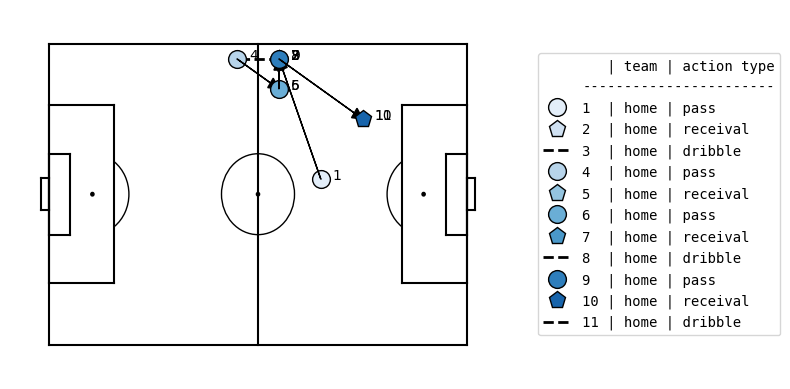

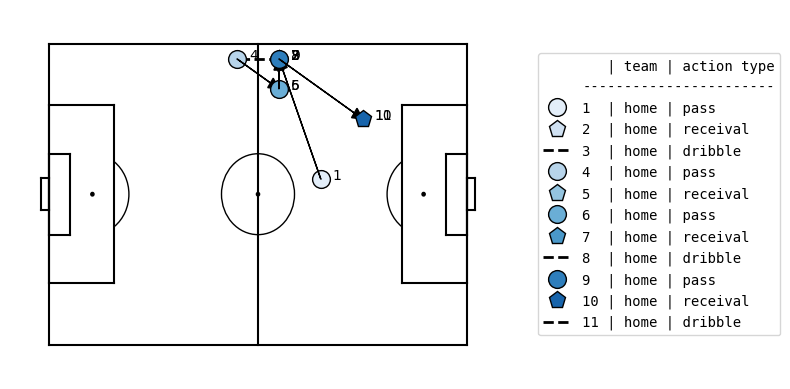

In [31]:
pid = 200

sequence = list(results.loc[pid-9:pid, 'action_token']) + [results.loc[pid, 'y_pred_markov']]
plot_action_sequence(sequence)

sequence = list(results.loc[pid-9:pid, 'action_token']) + [results.loc[pid, 'y_pred_transformer']]
plot_action_sequence(sequence)

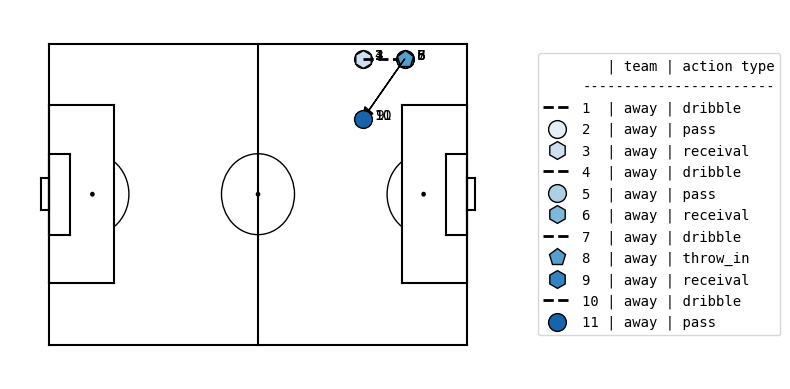

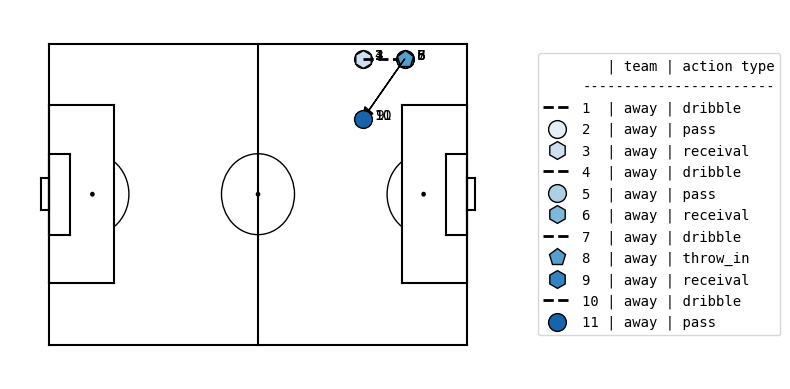

In [32]:
pid = 2000

sequence = list(results.loc[pid-9:pid, 'action_token']) + [results.loc[pid, 'y_pred_markov']]
plot_action_sequence(sequence)

sequence = list(results.loc[pid-9:pid, 'action_token']) + [results.loc[pid, 'y_pred_transformer']]
plot_action_sequence(sequence)